# Correlations between pairs of variables

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase
from data_processing import bins_per_trial
from timescale_functions import auto_correlogram, cross_correlogram, fit_tau

one = ONE()

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmp0gxujs_3/cache.zip Bytes: 115055338


100%|██████████| 109.72532081604004/109.72532081604004 [00:40<00:00,  2.69it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [3]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    session_trials['trial'] = np.arange(1, len(session_trials)+1)

    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    time_trial_180 = list(session_trials.loc[session_trials['trial']==180, 'stimOff_times'])[-1]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] > time_trial_90 * 10) & (design_matrix['Bin'] < time_trial_180 * 10) & (design_matrix['Bin'] > session_start * 10)]
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] > time_trial_90 * 10) & (design_matrix['Bin'] < time_trial_180 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [8]:
use_data = design_matrix.copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

## Trial bins

In [10]:
new_df = bins_per_trial(design_matrix, session_trials)


## Auto-correlation

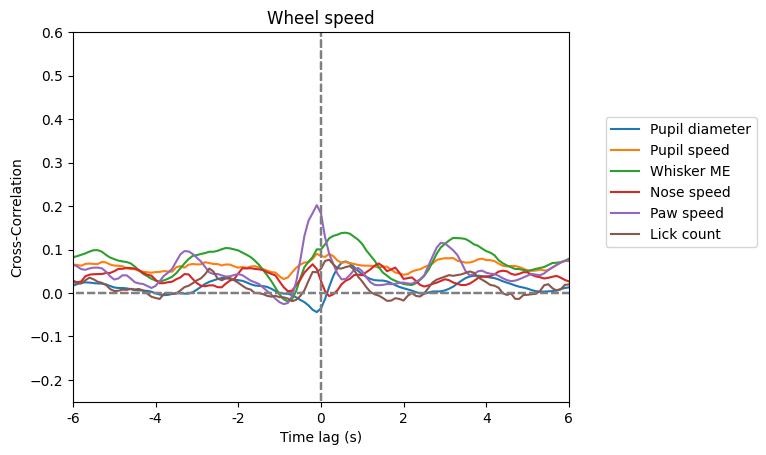

In [47]:
x = new_df['avg_wheel_vel']
x_label = 'Wheel speed'

var_names = ['avg_wheel_vel',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
var_names = ['pupil_diameter',
              'pupil_speed', 'whisker_me', 'nose_speed', 
              'l_paw_speed', 'Lick count']
var_labels = ['Pupil diameter',
              'Pupil speed', 'Whisker ME', 'Nose speed', 
              'Paw speed', 'Lick count']


for v, var in enumerate(var_names):
    
    y = new_df[var]
    lags_to_plot = 100
    cross_correlation = cross_correlogram(x, y, lags_to_plot)

    lags = np.arange(-lags_to_plot, lags_to_plot)

    # Plot the cross-correlation
    plt.plot(lags, cross_correlation, label=var_labels[v])
    plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    plt.vlines(0, -1, 1, color='gray', linestyles='--')
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.xticks([-60, -40, -20, 0, 20, 40, 60, 80], [-6, -4, -2, 0, 2, 4, 6, 8])
    # Add labels and legend
    plt.xlabel('Time lag (s)')
    plt.title(x_label)
    plt.ylim([-.25, .3])
    plt.xlim([-60, 60])
    plt.legend(bbox_to_anchor=(1.06, .4))
plt.show()

## Plot correlations per feature

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_69168/3140541515.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


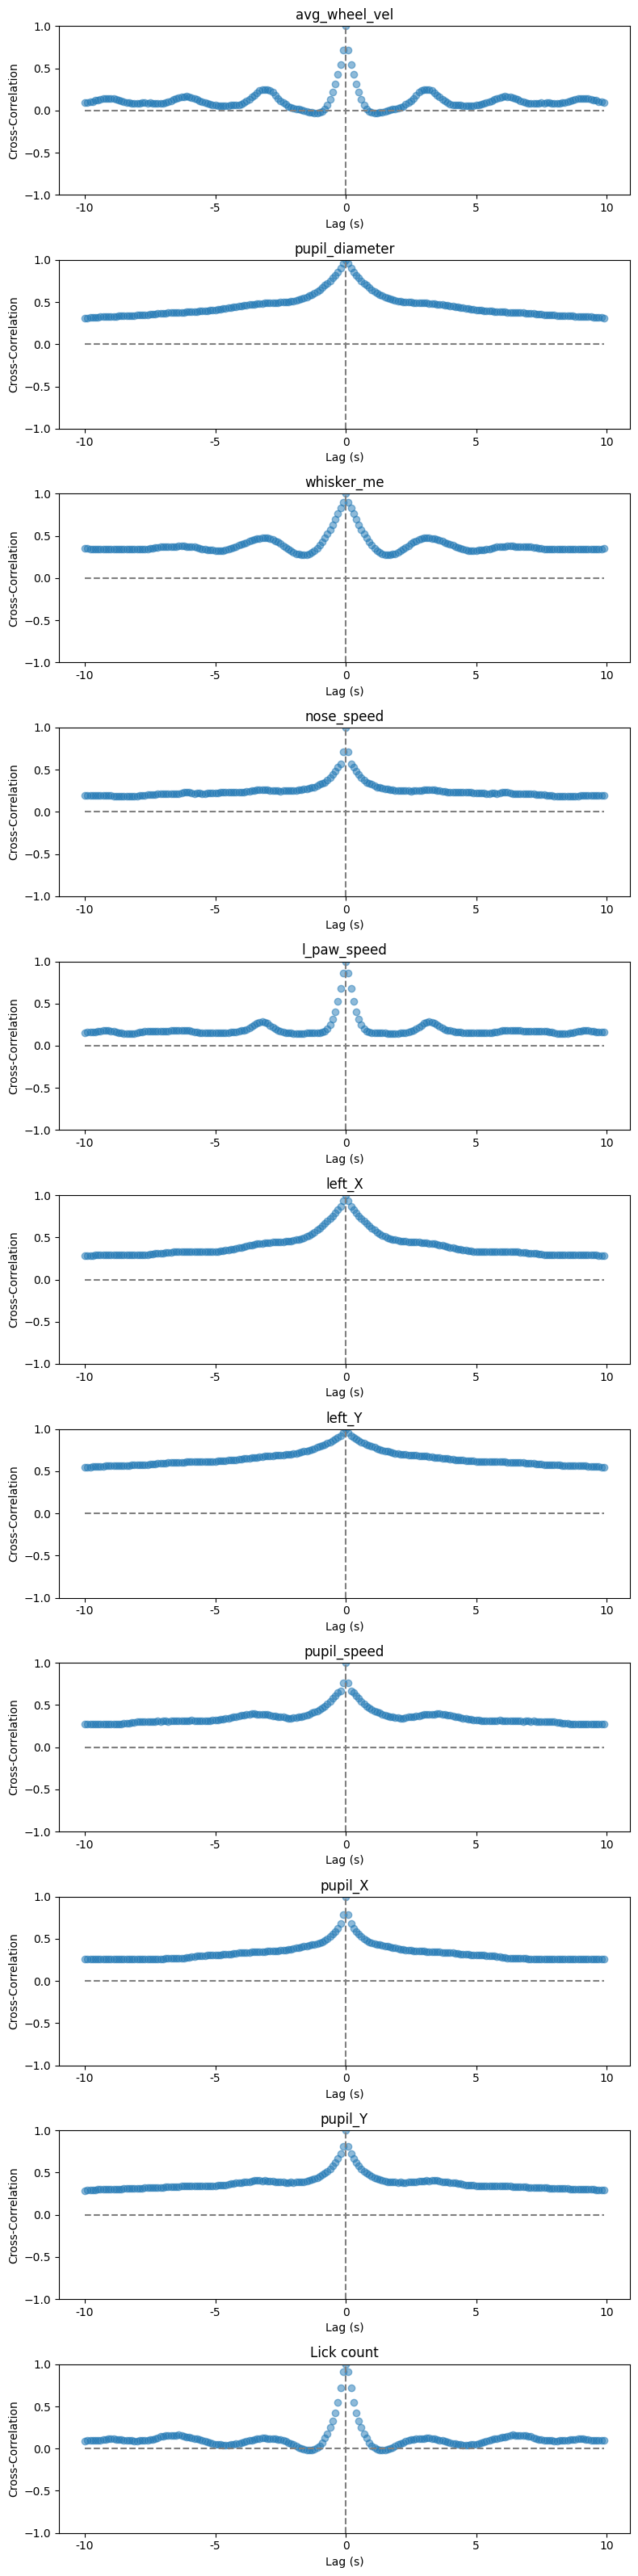

Text(0.5, 0, 'Time lag (s)')

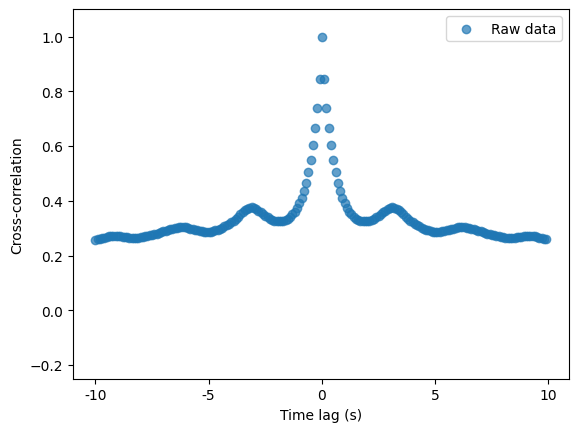

In [ ]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

lags_to_plot = 100
lags = np.arange(-lags_to_plot, lags_to_plot)

corrs = []

fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    
# fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 5])   
        
for i, feat in enumerate(features):
    
    x = use_data[feat]
    cross_correlation = cross_correlogram(x, lags_to_plot)

    # Save data
    if i == 0:
        corrs = [cross_correlation]
    else:
        corrs = np.vstack((corrs, cross_correlation))
        
    # Plot the cross-correlation once 
    #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
    ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
    ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
    ax[i].set_xlabel('Lag (s)')
    ax[i].set_ylabel('Cross-Correlation')
    ax[i].set_title(pc)
    ax[i].set_ylim([-1, 1])
    ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
    plt.tight_layout()

plt.show()
       
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-.25, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])


## Fit tau

The rate at which this autocorrelogram declines in a behaving mouse may be characterized as a time-constant, tau, of an exponentially decaying curve. Tau was fit using the Levenberg-Marquardt algorithm (non-linear least squares) using the SciPy optimization package.

In [ ]:

for v, var in enumerate(range(np.shape(corrs)[0])):
    end = 1000
    t = lags[lags_to_plot:end]
    y = corrs[v, lags_to_plot:end]


    popt, pcov = curve_fit(fit_tau, t, y)

    tau, c = popt
    y_fit = fit_tau(t, tau, c)
    
    plt.scatter(lags[lags_to_plot:end], y, alpha=0.7)
    plt.plot(lags[lags_to_plot:end], y_fit, label=features[var])
    #plt.legend(str(np.round(tau, decimals=1)))
    plt.legend()
    print(np.round(tau, decimals=1))

    plt.ylim([-.2, 1])
    plt.xlabel('Lag (100 ms)')
    plt.ylabel('Average cross-correlation')
    plt.xlim([0, lags_to_plot])
    

NameError: name 'corrs' is not defined

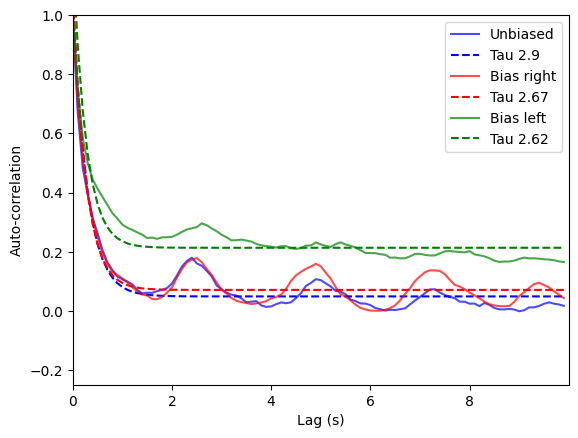

In [ ]:
block_colors = ['blue', 'red', 'green']
block_labels = ['Unbiased', 'Bias right', 'Bias left']
var_names = ['Wheel speed', 'Pupil diameter',
              'Whisker Motion Energy', 'Nose speed', 'Paw speed', 'Paw - X position', 'Paw - Y position',
              'Pupil speed', 'Pupil - X position', 'Pupil - Y position', 'Lick count']
# for v, var in enumerate(features):

for b, block in enumerate(blocks):   

    use_corrs = np.mean(block_corrs[block], axis=0)
    end = 4000
    t = lags[lags_to_plot:end]
    y = use_corrs[lags_to_plot:end]

    popt, pcov = curve_fit(fit_tau, t, y)
    tau, c = popt
    y_fit = fit_tau(t, tau, c)
    
    plt.plot(lags[lags_to_plot:end], y, alpha=0.7, label=block_labels[b], color=block_colors[b])
    plt.plot(lags[lags_to_plot:end], y_fit, label=str('Tau ' + str(np.round(tau, 2))), color=block_colors[b], linestyle='dashed')
    plt.legend()
    plt.ylim([-.25, 1])
    plt.xlabel('Lag (s)')
    plt.ylabel('Auto-correlation')
    plt.xticks([0, 20, 40, 60, 80, 100], [0, 2, 4, 6, 8, 10])
    plt.xticks([0, 20, 40, 60, 80], [0, 2, 4, 6, 8])
    # Add labels and legend
    plt.xlim([0, 100])
    plt.xlim([0, lags_to_plot])
    # plt.title(str(var_names[v]))
plt.show()


In [1]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats
from scipy import signal

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_lick_times, get_dlc_XYs, find_nearest, get_raw_and_smooth_ME, get_raw_and_smooth_position, get_ME, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin


In [2]:
one = ONE()

In [4]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))
example_session = 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9'
#example_session = 'b39752db-abdb-47ab-ae78-e8608bbf50ed'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

In [4]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'

## Correlation between pupil size and wheel movement

### Session-specific data

In [5]:
# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = prepro(session_trials.to_df())

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

# Pupil diameter
pupil_dia_raw, pupil_dia_smooth, _, _ = (
    get_raw_and_smooth_position(example_session, video_type, ephys=True, position_function=get_pupil_diameter))
pupil_t, XYs = get_dlc_XYs(example_session, view=video_type, likelihood_thresh=0.9)

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-19/001/alf/#2023-04-20#/_ibl_leftCamera.times.npy: 100%|██████████| 2.25M/2.25M [00:01<00:00, 1.33MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [6]:
session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']

# Initialize dataframe
wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


In [33]:
# Merge data
all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

# Remove wheel disp (was used just to get onset times alignment with bins)
data_df = all_metrics.dropna().drop_duplicates()
data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

### Plot pupil diameter and wheel speed

/tmp/ipykernel_32209/2010342594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Bin'] = use_data['Bin'] / 10


Text(0.5, 1.0, 'b39752db-abdb-47ab-ae78-e8608bbf50ed')

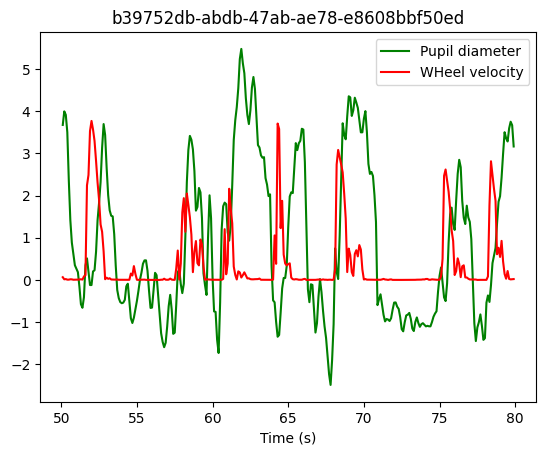

In [44]:
use_data = data_df.loc[(data_df['Bin']<800) & (data_df['Bin']>500)]
use_data['Bin'] = use_data['Bin'] / 10

plt.plot(use_data['Bin'], use_data['pupil_diameter'], color='green', label='Pupil diameter')
plt.plot(use_data['Bin'], np.abs(use_data['avg_wheel_vel']), color='red', label='WHeel velocity')
plt.legend()
plt.xlabel('Time (s)')
plt.title(example_session)


#sns.lineplot(x='Bin', y='pupil_diameter', data=use_data)

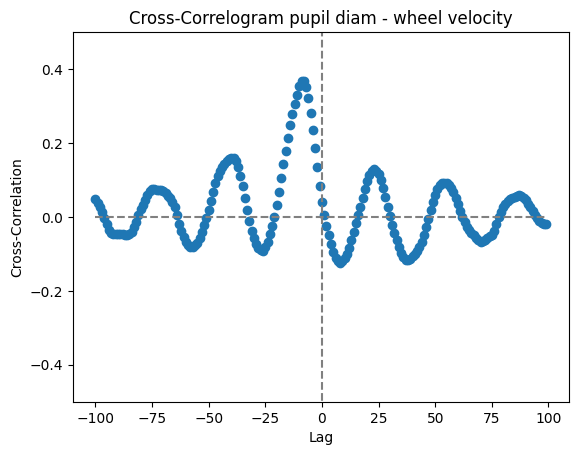

In [45]:
x = data_df['pupil_diameter']
y = data_df['avg_wheel_vel']

# Calculate the lag values corresponding to the cross-correlation
lags = np.arange(-100, 100)

# Compute the cross-correlation using np.correlate
cross_correlation = np.zeros(len(lags)) * np.nan
len_timeseries = len(x)
for l, lag in enumerate(lags):
    if lag < 0:
        x_chunk = np.array(x[-lag:])
        y_chunk = np.array(y[:lag])
    elif lag == 0:
        x_chunk = np.array(x)
        y_chunk = np.array(y)
    elif lag > 0:
        x_chunk = np.array(x[0:-lag])
        y_chunk = np.array(y[lag:])
    cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
    #np.sum(x_chunk * y[lag-lag:len(x_chunk)]) / ((len_timeseries-lag)* np.std(x_chunk) * np.std(y[lag-lag:len(x_chunk)]))

# Plot the cross-correlation
import matplotlib.pyplot as plt
plt.scatter(lags, cross_correlation)
plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
plt.vlines(0, -1, 1, color='gray', linestyles='--')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlogram pupil diam - wheel velocity')
plt.ylim([-.5, .5])
plt.show()

### Plot wheel velocity per pupil size bin

In [86]:
# Bin data on both axes
bin_edges = np.arange(-50, 50, 2.5)
data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges, labels=bin_edges[:-1])

(15.0, 24.0)

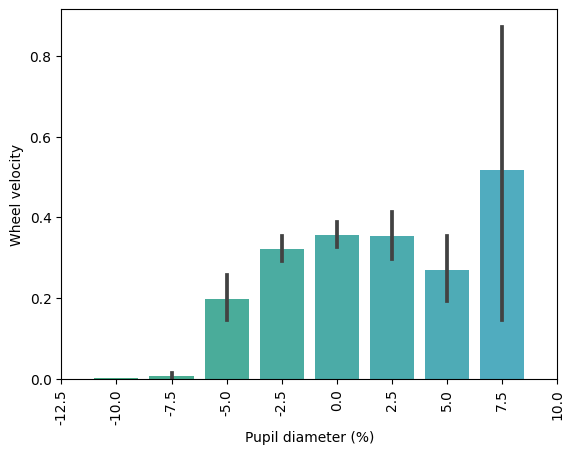

In [88]:
# Plot
sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
plt.xlabel('Pupil diameter (%)')
plt.ylabel('Wheel velocity')
plt.xticks(rotation=90)
b = np.arange(0, len(bin_edges), 1)
min = b[np.where(bin_edges==np.min(data_df['pupil_bin']))][0]
max = b[np.where(bin_edges==np.max(data_df['pupil_bin']))][0]
plt.xlim([min-1, max+1])


### Plot with lag corresponding to maximum correlation

In [89]:
max_corr = lags[np.where(cross_correlation==np.max(cross_correlation))][0]
max_corr

-9

Shift data to get maximum correlation

In [85]:
# Shorten data frame in order to shift variables according to the maximum correlation lag

x = data_df['pupil_diameter']
y = data_df['avg_wheel_vel']
lag = max_corr
if max_corr < 0:
    x_chunk = np.array(x[-lag:])
    y_chunk = np.array(y[:lag])
    short_df = data_df[-lag:]
    short_df['x'] = x_chunk
    short_df['y'] = y_chunk
elif max_corr == 0:
    x_chunk = np.array(x)
    y_chunk = np.array(y)
    short_df = data_df.copy()
elif max_corr > 0:
    x_chunk = np.array(x[0:-lag])
    y_chunk = np.array(y[0:-lag])
    short_df = data_df[-lag:]
    short_df['x'] = x_chunk
    short_df['y'] = y_chunk

/tmp/ipykernel_32209/811261269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['x'] = x_chunk
/tmp/ipykernel_32209/811261269.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['y'] = y_chunk


In [92]:
# Bin data on both axes
bin_edges = np.arange(-50, 50, 2.5)
short_df['pupil_bin'] = pd.cut(short_df['pupil_diameter'], bins=bin_edges, labels=bin_edges[:-1])

/tmp/ipykernel_32209/868204677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['pupil_bin'] = pd.cut(short_df['pupil_diameter'], bins=bin_edges, labels=bin_edges[:-1])


(15.0, 24.0)

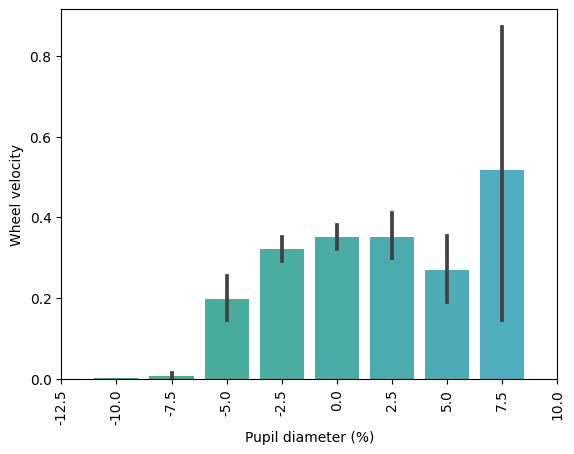

In [93]:
# Plot
sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=short_df)  # 
plt.xlabel('Pupil diameter (%)')
plt.ylabel('Wheel velocity')
plt.xticks(rotation=90)
b = np.arange(0, len(bin_edges), 1)
min = b[np.where(bin_edges==np.min(short_df['pupil_bin']))][0]
max = b[np.where(bin_edges==np.max(short_df['pupil_bin']))][0]
plt.xlim([min-1, max+1])


## Relationship between reaction/response/consumption time and ME peak

In [5]:
def align_stimOn(df, trials):

    # Define the bin edges array
    trial_edges = list(trials['stimOn_times'])

    onsets = pd.DataFrame({'onset_times': trial_edges,
                          'Trial': np.arange(0, len(trial_edges), 1)})
    
    # Merge dataframes
    df = df.merge(onsets, on='Trial')
        
    return df


In [6]:
# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = prepro(session_trials.to_df())

# Motion energy of whisker pad
me_times, motion_energy = get_ME(example_session, video_type)
X_center0, smooth_me, _, _ = get_raw_and_smooth_ME(motion_energy, video_type='left', ephys=True)       
smooth_me = zscore(smooth_me, nan_policy='omit') 

In [23]:
session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']
event = 'stimOn_times'
t_init = 0.5
t_end = 2

# Align on stimulus onset
me_aligned = timeseries_PSTH(me_times, smooth_me, session_trials, event, t_init, t_end, subtract_baseline=False)
#me_aligned['value'] = me_aligned['value'].rolling(3).mean()

# Get peak of
max_ME = pd.DataFrame(me_aligned.groupby(['feedback_time'])['value'].max())
max_ME = max_ME.reset_index(level=[0])
max_ME = max_ME.rename(columns={'value':'max_ME'})

merged = me_aligned.merge(max_ME, on='feedback_time', how='inner')
reduced = merged.loc[merged['value']==merged['max_ME']]


0
[-0.49945005 -0.48278505 -0.46615338 -0.44948838 -0.43285671 -0.41619171
 -0.39956004 -0.38289504 -0.36626337 -0.34959837 -0.3329667  -0.3163017
 -0.29967003 -0.28300503 -0.26637336 -0.24970836 -0.23307669 -0.21641169
 -0.19978002 -0.18311502 -0.16648335 -0.14981835 -0.13318668 -0.11652168
 -0.09989001 -0.08322501 -0.06659334 -0.04992834 -0.03329667 -0.01663167
  0.          0.016665    0.03329667  0.04996167  0.06659334  0.08325834
  0.09989001  0.11655501  0.13318668  0.14985168  0.16648335  0.18314835
  0.19978002  0.21644502  0.23307669  0.24974169  0.26637336  0.28303836
  0.29967003  0.31633503  0.3329667   0.3496317   0.36626337  0.38292837
  0.39956004  0.41622504  0.43285671  0.44948838  0.46615338  0.48278505
  0.49945005  0.51608172  0.53274672  0.54937839  0.56604339  0.58267506
  0.59934006  0.61597173  0.63263673  0.6492684   0.6659334   0.68256507
  0.69923007  0.71586174  0.73252674  0.74915841  0.76582341  0.78245508
  0.79912008  0.81575175  0.83241675  0.84904842  

Text(0, 0.5, 'Z-scored Motion energy')

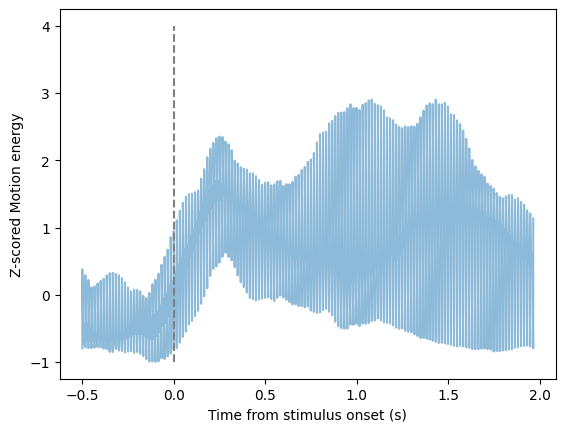

In [24]:
use_data = me_aligned.loc[me_aligned['feedback_time']< 0.5]

use_data = use_data.rolling(3).mean()
sns.lineplot(x='variable', y='value', data=use_data, estimator=None, alpha=0.5)
plt.vlines(0, -1, 4, color='grey', linestyles='--')
plt.xlabel('Time from stimulus onset (s)')
plt.ylabel('Z-scored Motion energy')


-0.20104182128610956

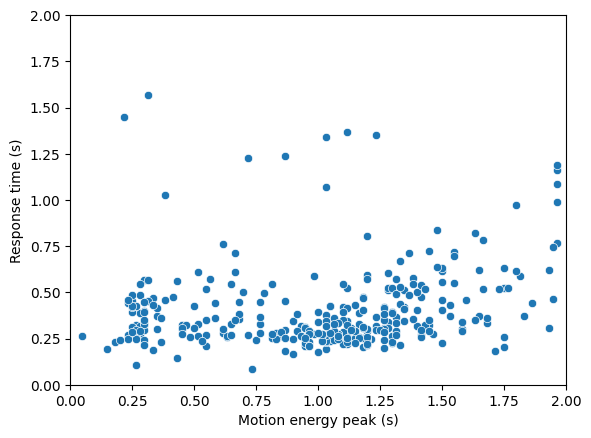

In [25]:
# Find maximum ME for each trial
smooth = reduced.copy()
sns.scatterplot(x='variable', y='response_time', data=reduced)
plt.ylim([0,t_end])
plt.xlim([0,t_end])
plt.xlabel('Motion energy peak (s)')
plt.ylabel('Response time (s)')
stats.pearsonr(reduced['variable'], reduced['response_time']).statistic

Text(0, 0.5, 'Z-scored Motion energy')

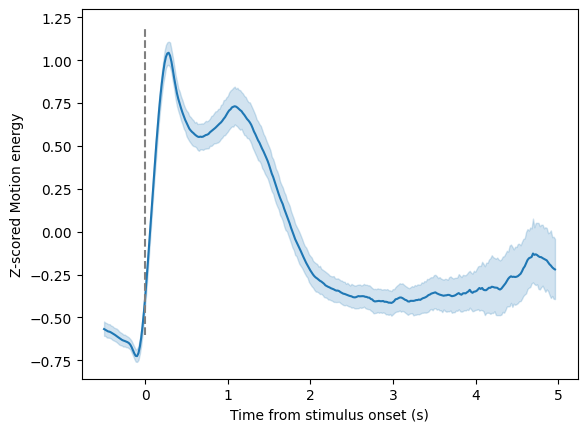

In [22]:
sns.lineplot(x='variable', y='value', data=me_aligned)
plt.vlines(0, -0.6, 1.2, color='grey', linestyles='--')
plt.xlabel('Time from stimulus onset (s)')
plt.ylabel('Z-scored Motion energy')

## Movement entraining with licking

In [7]:
# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = prepro(session_trials.to_df())

# Licks
session_licks = get_lick_times(example_session, combine=False, video_type=video_type)


# Motion energy of whisker pad
me_times, motion_energy = get_ME(example_session, video_type)
X_center0, smooth_me, _, _ = get_raw_and_smooth_ME(motion_energy, video_type='left', ephys=True)       
smooth_me = zscore(smooth_me, nan_policy='omit') 

event = 'stimOn_times'
t_init = 0.5
t_end = 2

# Align on stimulus onset
me_aligned = timeseries_PSTH(me_times, smooth_me, session_trials, event, t_init, t_end, subtract_baseline=False)

#lick_aligned = timeseries_PSTH(me_times, smooth_me, session_trials, event, t_init, t_end, subtract_baseline=False)
licking = lick_rate(bin_size, session_licks, session_trials)



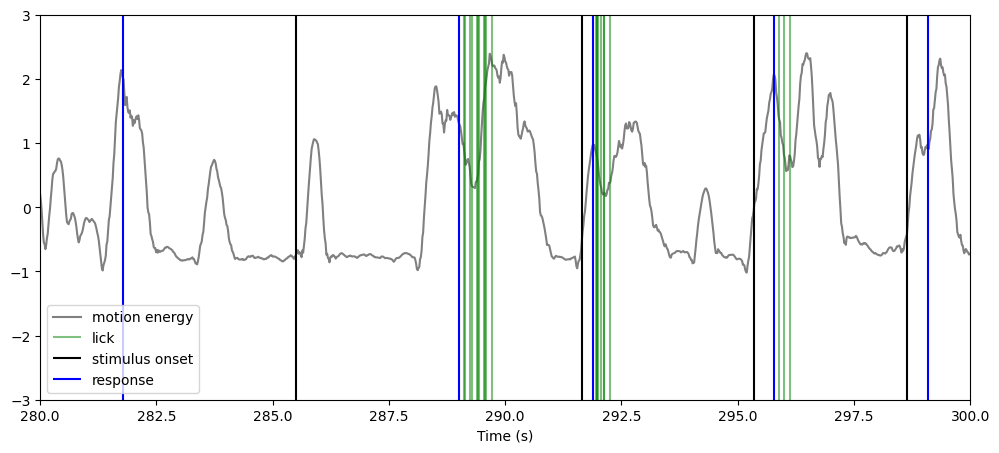

In [46]:
onsets = session_trials.stimOn_times
response = session_trials.response_times

t_init =280
t_end = t_init + 20
f = plt.figure(figsize=(12, 5))
plt.plot(me_times, smooth_me, label='motion energy', color='grey')

plt.vlines(session_licks, -3, 3, color='green', label='lick', alpha=0.5)
plt.vlines(onsets, -3, 3, color='black', label='stimulus onset')
plt.vlines(response, -3, 3, color='blue', label='response')

plt.xlim([t_init,t_end])
plt.ylim([-3, 3])
plt.xlabel('Time (s)')
plt.legend()

Text(0, 0.5, 'Z-scored Motion energy')

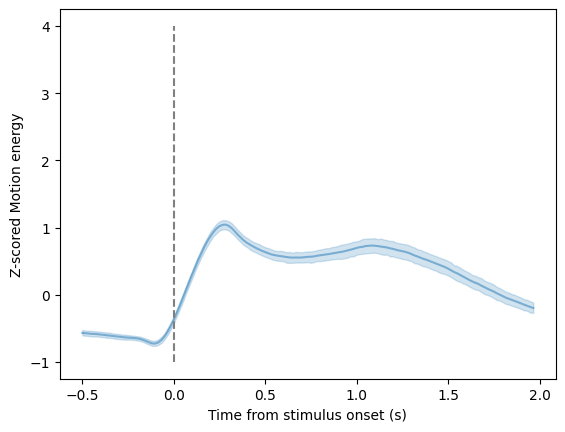

In [12]:
        sns.lineplot(x='variable', y='value', data=lick_aligned, alpha=0.5)
        plt.vlines(0, -1, 4, color='grey', linestyles='--')
        plt.xlabel('Time from stimulus onset (s)')
        plt.ylabel('Z-scored Motion energy')